<a href="https://colab.research.google.com/github/ZeroJoon2/DeepLearning/blob/main/%EA%B5%90%EC%9E%AC%EC%BD%94%EB%93%9C_chapter10_dl_for_timeseries_i%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이 노트북은 [케라스 창시자에게 배우는 딥러닝 2판](https://tensorflow.blog/kerasdl2/)의 예제 코드를 담고 있습니다.

<table align="left">
    <tr>
        <td>
            <a href="https://colab.research.google.com/github/rickiepark/deep-learning-with-python-2nd/blob/main/chapter10_dl-for-timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
        </td>
    </tr>
</table>

# 시계열을 위한 딥러닝

## 다양한 종류의 시계열 작업

## 기온 예측 문제

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-01-20 00:45:44--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 3.5.0.41, 52.217.202.136, 52.217.15.62, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|3.5.0.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  4.99MB/s    in 2.6s    

2025-01-20 00:45:48 (4.99 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**예나 날씨 데이터셋 조사하기**

In [14]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**데이터 파싱**

In [15]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**전체 기온을 그래프로 그리기**

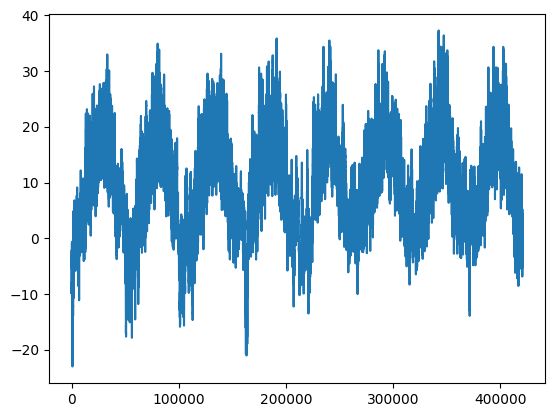

In [16]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.show()

**처음 10일간의 기온을 그래프로 그리기**

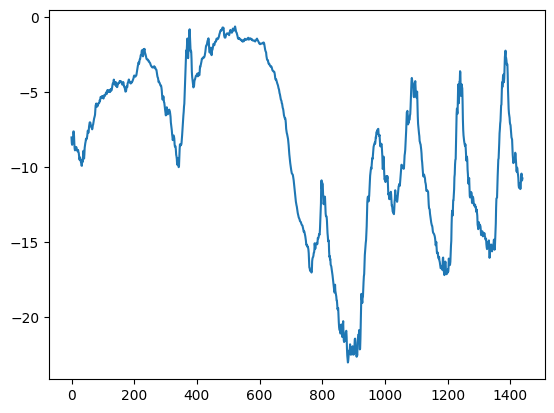

In [17]:
plt.plot(range(1440), temperature[:1440])
plt.show()

**각 분할에 사용할 샘플 수 계산하기**

In [18]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### 데이터 준비

**데이터 정규화**

In [19]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

5일치 데이터로 24시간 뒤 온도 예측

In [20]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**훈련, 검증, 테스트 데이터셋 만들기**

In [21]:
sampling_rate = 6 # 시간당 1개
sequence_length = 120 # 5일치 당 윈도우
delay = sampling_rate * (sequence_length + 24 - 1) #이전 시퀀스 끝에서 지연을 주고 다음 시퀀스
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples) # 50%의 갯수 > 마지막 인덱스

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples) # 검증 데이터의 인덱스

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**훈련 데이터셋의 배치 크기 확인하기**

In [22]:
for samples, targets in train_dataset:
    print("샘플 크기:", samples.shape)
    print("타깃 크기:", targets.shape)
    break

샘플 크기: (256, 120, 14)
타깃 크기: (256,)


### 상식 수준의 기준점

**상식적인 기준 모델의 MAE 계산하기**

In [23]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"검증 MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"테스트 MAE: {evaluate_naive_method(test_dataset):.2f}")

검증 MAE: 2.44
테스트 MAE: 2.62


### 기본적인 머신 러닝 모델 시도해 보기

**밀집 연결 모델 훈련하고 평가하기**

In [30]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Reshape((-1, raw_data.shape[-1]))(inputs)  # Reshape if needed
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x) #예측치
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]

In [31]:
# 훈련
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 57ms/step - loss: 113.5770 - mae: 8.6632 - val_loss: 67.7234 - val_mae: 6.7606
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 76s 52ms/step - loss: 77.0529 - mae: 7.1092 - val_loss: 65.6985 - val_mae: 6.6700
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - loss: 76.2051 - mae: 7.0709 - val_loss: 65.6508 - val_mae: 6.6693
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - loss: 76.1678 - mae: 7.0708 - val_loss: 65.6090 - val_mae: 6.6676
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 89s 61ms/step - loss: 76.1516 - mae: 7.0698 - val_loss: 65.3884 - val_mae: 6.6566
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - loss: 76.0951 - mae: 7.0676 - val_loss: 65.3236 - val_mae: 6.6533
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 51s 61ms/step - loss: 76.2037 - mae: 7.0719 - val_loss: 65.5722 - val_mae: 6.6660
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 53ms/step - loss: 76.0844 - mae: 7.0664 - val_loss: 65.6205 - val_mae: 6.6685
Epoch 9/10
819/819 ━━━━

In [32]:
model = keras.models.load_model("jena_dense.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - loss: 66.0768 - mae: 6.6522
테스트 MAE: 6.64


**결과 그래프 그리기**

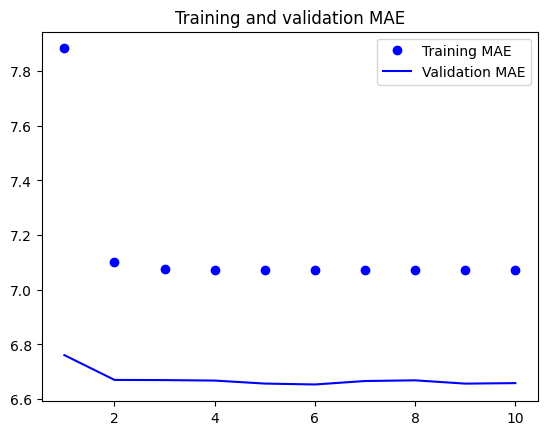

In [33]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 1D 합성곱 모델 시도해 보기

In [35]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 51s 57ms/step - loss: 31.0267 - mae: 4.2956 - val_loss: 15.9494 - val_mae: 3.1887
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 51s 62ms/step - loss: 15.8312 - mae: 3.1531 - val_loss: 15.1394 - val_mae: 3.0846
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 51s 62ms/step - loss: 14.5383 - mae: 3.0235 - val_loss: 15.4227 - val_mae: 3.0821
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - loss: 13.7561 - mae: 2.9339 - val_loss: 14.5051 - val_mae: 3.0071
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 61ms/step - loss: 13.0888 - mae: 2.8593 - val_loss: 14.5247 - val_mae: 3.0228
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 61ms/step - loss: 12.5531 - mae: 2.8002 - val_loss: 15.9815 - val_mae: 3.1797
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - loss: 12.0871 - mae: 2.7516 - val_loss: 14.0558 - val_mae: 2.9685
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 76s 54ms/step - loss: 11.6415 - mae: 2.6990 - val_loss: 14.3466 - val_mae: 3.0081
Epoch 9/10
819/819 ━━━━━

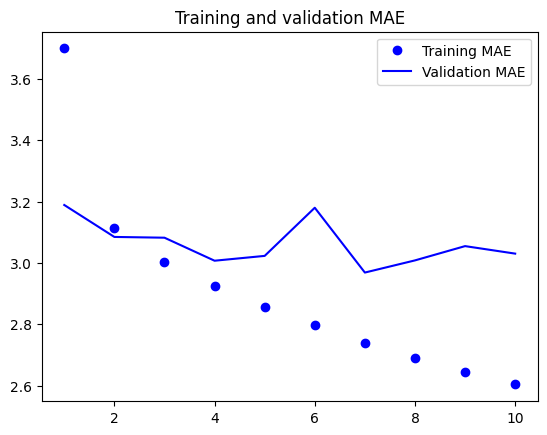

In [36]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 첫 번째 순환 신경망

**간단한 LSTM 기반 모델**

In [37]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs) #layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 51s 58ms/step - loss: 71.8197 - mae: 6.4732 - val_loss: 13.0486 - val_mae: 2.7497
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 80s 57ms/step - loss: 11.9796 - mae: 2.6773 - val_loss: 9.9030 - val_mae: 2.4534
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 83s 58ms/step - loss: 10.1607 - mae: 2.4824 - val_loss: 9.8236 - val_mae: 2.4281
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 58ms/step - loss: 9.7265 - mae: 2.4278 - val_loss: 9.5762 - val_mae: 2.3954
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 81s 57ms/step - loss: 9.3902 - mae: 2.3878 - val_loss: 9.5135 - val_mae: 2.3928
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 57ms/step - loss: 9.1455 - mae: 2.3572 - val_loss: 9.5817 - val_mae: 2.4003
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 48s 58ms/step - loss: 8.9219 - mae: 2.3298 - val_loss: 9.7098 - val_mae: 2.4249
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 47s 57ms/step - loss: 8.7111 - mae: 2.3000 - val_loss: 9.5367 - val_mae: 2.3990
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━━

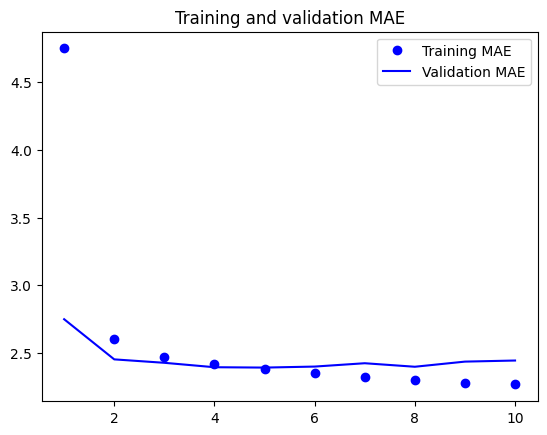

In [38]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## 순환 신경망 이해하기

**넘파이로 구현한 간단한 RNN**

In [ ]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### 케라스의 순환 층

**어떤 길이의 시퀀스도 처리할 수 있는 RNN 층**

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**마지막 출력 스텝만 반환하는 RNN 층**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**전체 출력 시퀀스를 반환하는 RNN 층**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**스태킹(stacking) RNN 층**

In [ ]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## 순환 신경망의 고급 사용법

### 과대적합을 감소하기 위해 순환 드롭아웃 사용하기

**드롭아웃 규제를 적용한 LSTM 모델 훈련하고 평가하기**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 훈련 속도를 놓이기 위해 순환 드롭아웃을 제외합니다.
#x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.LSTM(32)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 57s 66ms/step - loss: 25.4986 - mae: 3.7522 - val_loss: 9.8706 - val_mae: 2.4336
Epoch 2/50
819/819 [==============================] - 45s 55ms/step - loss: 14.4447 - mae: 2.9416 - val_loss: 9.6151 - val_mae: 2.4041
Epoch 3/50
819/819 [==============================] - 45s 55ms/step - loss: 13.3854 - mae: 2.8292 - val_loss: 9.1080 - val_mae: 2.3482
Epoch 4/50
819/819 [==============================] - 45s 54ms/step - loss: 12.6074 - mae: 2.7476 - val_loss: 9.1785 - val_mae: 2.3614
Epoch 5/50
819/819 [==============================] - 46s 56ms/step - loss: 11.9744 - mae: 2.6818 - val_loss: 9.6602 - val_mae: 2.4325
Epoch 6/50
819/819 [==============================] - 52s 64ms/step - loss: 11.5510 - mae: 2.6302 - val_loss: 9.8566 - val_mae: 2.4397
Epoch 7/50
819/819 [==============================] - 45s 55ms/step - loss: 11.1829 - mae: 2.5894 - val_loss: 9.9830 - val_mae: 2.4565
Epoch 8/50
819/819 [==============================] - 5

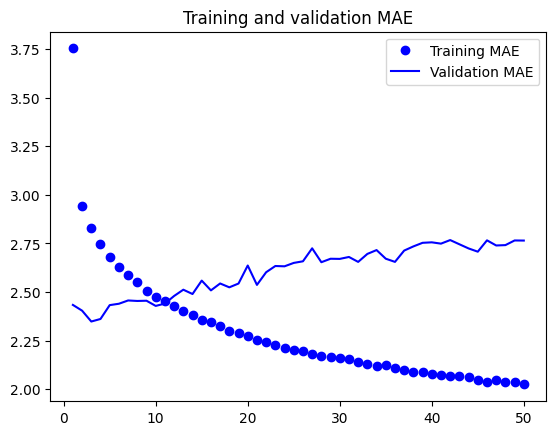

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### 스태킹 순환 층

**드롭아웃 규제와 스태킹을 적용한 GRU 모델을 훈련하고 평가하기**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 훈련 속도를 놓이기 위해 순환 드롭아웃을 제외합니다.
# x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
# x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.GRU(32, return_sequences=True)(inputs)
x = layers.GRU(32)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.h5")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 51s 58ms/step - loss: 22.8440 - mae: 3.5376 - val_loss: 10.0216 - val_mae: 2.4642
Epoch 2/50
819/819 [==============================] - 48s 58ms/step - loss: 13.4467 - mae: 2.8365 - val_loss: 9.1210 - val_mae: 2.3532
Epoch 3/50
819/819 [==============================] - 45s 55ms/step - loss: 12.5574 - mae: 2.7434 - val_loss: 8.7419 - val_mae: 2.2949
Epoch 4/50
819/819 [==============================] - 46s 56ms/step - loss: 11.7473 - mae: 2.6557 - val_loss: 9.0236 - val_mae: 2.3442
Epoch 5/50
819/819 [==============================] - 54s 65ms/step - loss: 11.1289 - mae: 2.5857 - val_loss: 9.2370 - val_mae: 2.3689
Epoch 6/50
819/819 [==============================] - 45s 55ms/step - loss: 10.4581 - mae: 2.5057 - val_loss: 9.5454 - val_mae: 2.4172
Epoch 7/50
819/819 [==============================] - 47s 58ms/step - loss: 9.8363 - mae: 2.4268 - val_loss: 10.0694 - val_mae: 2.4758
Epoch 8/50
819/819 [==============================] - 

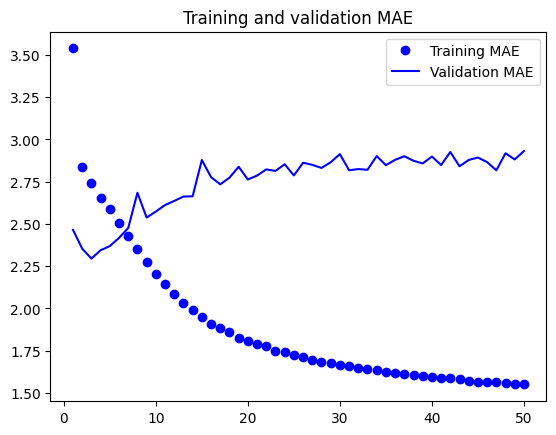

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 양방향 RNN 사용하기

시퀀스를 거꾸로 뒤집어 LSTM 모델 훈련하기 (책에는 없음)

In [ ]:
def train_generator():
    while True:
        for samples, targets in train_dataset:
            yield samples[:, ::-1, :], targets

def val_generator():
    while True:
        for samples, targets in val_dataset:
            yield samples[:, ::-1, :], targets

train_gen = train_generator()
val_gen = val_generator()

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 훈련 속도를 놓이기 위해 순환 드롭아웃을 제외합니다.
# x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.LSTM(32)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_gen,
                    epochs=10,
                    steps_per_epoch=819,
                    validation_data=val_gen,
                    validation_steps=410)

Epoch 1/10
819/819 [==============================] - 58s 68ms/step - loss: 34.4427 - mae: 4.4943 - val_loss: 17.2340 - val_mae: 3.2700
Epoch 2/10
819/819 [==============================] - 53s 65ms/step - loss: 21.8827 - mae: 3.6623 - val_loss: 16.7471 - val_mae: 3.2083
Epoch 3/10
819/819 [==============================] - 55s 67ms/step - loss: 20.3650 - mae: 3.5217 - val_loss: 16.0861 - val_mae: 3.1253
Epoch 4/10
819/819 [==============================] - 82s 92ms/step - loss: 17.7713 - mae: 3.2862 - val_loss: 13.3988 - val_mae: 2.8408
Epoch 5/10
819/819 [==============================] - 49s 60ms/step - loss: 15.6091 - mae: 3.0858 - val_loss: 12.8040 - val_mae: 2.7785
Epoch 6/10
819/819 [==============================] - 115s 140ms/step - loss: 14.6476 - mae: 2.9809 - val_loss: 12.5205 - val_mae: 2.7213
Epoch 7/10
819/819 [==============================] - 48s 58ms/step - loss: 13.9296 - mae: 2.9091 - val_loss: 12.2423 - val_mae: 2.6778
Epoch 8/10
819/819 [==========================

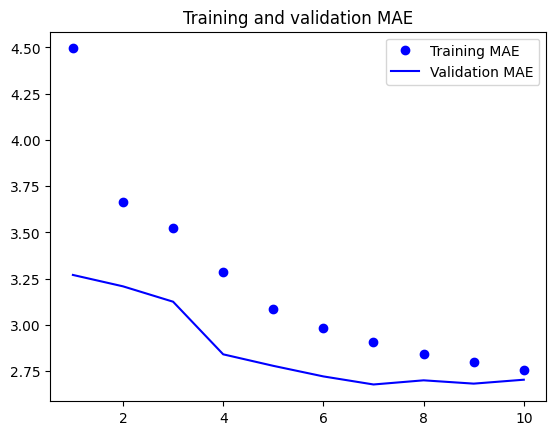

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**양방향 LSTM 모델 훈련하고 평가하기**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 55s 62ms/step - loss: 26.2686 - mae: 3.6970 - val_loss: 11.1051 - val_mae: 2.5860
Epoch 2/10
819/819 [==============================] - 48s 58ms/step - loss: 9.6917 - mae: 2.4327 - val_loss: 9.7543 - val_mae: 2.4046
Epoch 3/10
819/819 [==============================] - 47s 57ms/step - loss: 8.9986 - mae: 2.3375 - val_loss: 9.4536 - val_mae: 2.3768
Epoch 4/10
819/819 [==============================] - 47s 57ms/step - loss: 8.4802 - mae: 2.2696 - val_loss: 9.7171 - val_mae: 2.4206
Epoch 5/10
819/819 [==============================] - 48s 58ms/step - loss: 8.0960 - mae: 2.2161 - val_loss: 9.4793 - val_mae: 2.3819
Epoch 6/10
819/819 [==============================] - 49s 59ms/step - loss: 7.7758 - mae: 2.1717 - val_loss: 9.8579 - val_mae: 2.4301
Epoch 7/10
819/819 [==============================] - 47s 58ms/step - loss: 7.5232 - mae: 2.1358 - val_loss: 9.7900 - val_mae: 2.4127
Epoch 8/10
819/819 [==============================] - 48s 59

### 더 나아가서

## 요약